In [4]:
# In order to force the reload of modules
%load_ext autoreload
%autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import heapq
import numpy as np
import pandas as pd
from typing import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from ml.rl.core import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""
Showing information about the environment
"""


with gym.make("MountainCar-v0") as env:
    print("observation shape:", env.reset().shape)
    print("action space:", {env.action_space.sample() for _ in range(100)})

observation shape: (2,)
action space: {0, 1, 2}


In [3]:
def try_agent(agent: Agent):
    with gym.make("MountainCar-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print("Total reward {0:.2f}".format(total_reward))

In [6]:
"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


try_agent(RandomAgent())

Total reward -200.00


In [7]:
"""
Cross Entropy Method:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)

The problem here is that it will never make progress, because we never have episodes
with something else than -200 as reward. We could change the way the reward is done
but this is not the case here.

DOOMED TO FAIL
"""

pass

3000/3000 (100.00%) - 11.69 it/s


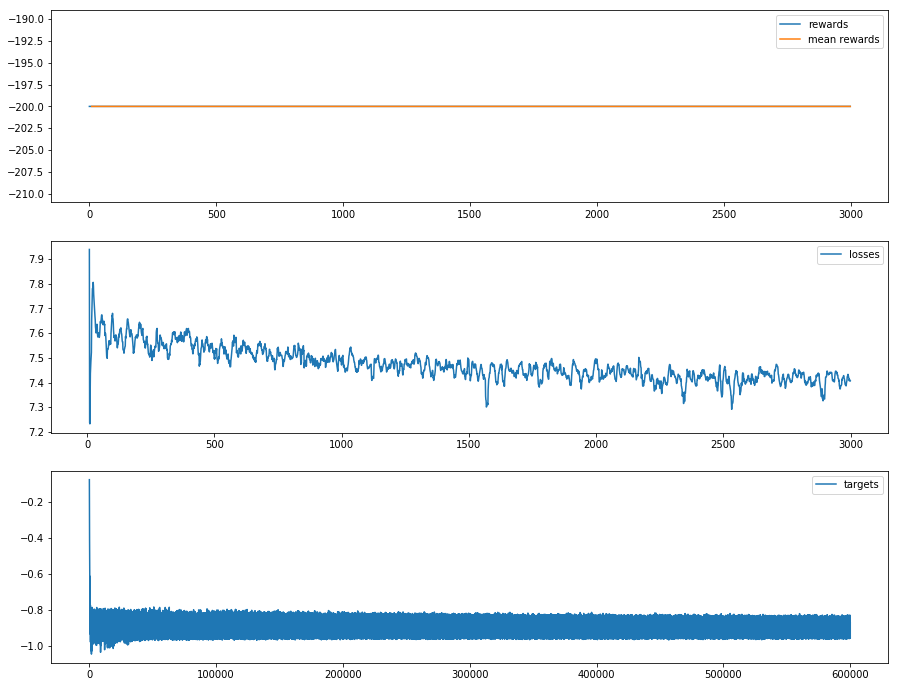

In [12]:
"""
With Deep SARSA Learning

SHOW NOT PROGRESS...
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 200),
            # nn.ReLU(),
            nn.Linear(200, 3))

    def forward(self, xs):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        return ys

    
class PolicyAgent:
    def __init__(self, sarsa_net):
        self.sarsa_net = sarsa_net
        
    def get_action(self, env, state):
        action_values = self.sarsa_net(state)
        _, i = torch.max(action_values, dim=-1)
        return i.item()

    
def epsilon_greedy_action(policy: nn.Module, state, epsilon) -> Tuple[int, float, torch.FloatTensor]:
    action_values = policy(state)
    if np.random.rand(1) < epsilon:
        action = env.action_space.sample()
        return action, action_values[action], action_values
    else:
        action_value, action = torch.max(action_values, dim=-1)
        return action.item(), action_value, action_values
    

def train_sarsa_learning(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float,
    epsilon: float, epsilon_decay: float,
    show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []

    criterion = nn.MSELoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for episode in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        action, action_value, _ = epsilon_greedy_action(policy, state, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action, next_action_value, next_action_values = epsilon_greedy_action(policy, next_state, epsilon)
            
            # Compute the target values
            if not done:
                max_q, _ = torch.max(next_action_values, dim=-1) # TODO - this is in fact Q-Learning now
                target = reward + discount * max_q.detach()
            else:
                target = torch.tensor(reward)

            # Apply the bellman update
            optimizer.zero_grad()
            loss = criterion(action_value, target)
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
            
            # Moving to next state
            episode_reward += reward
            state = next_state
            action = next_action
            action_value = next_action_value
            targets.append(target)

        # Criteria of success
        if episode_reward > -200.:
            count_success += 1
            epsilon *= epsilon_decay
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()

    
"""
Training
"""

sarsa_net = PolicyNet()
with gym.make("MountainCar-v0") as env:
    train_sarsa_learning(
        env, policy=sarsa_net, episodes=3000, discount=0.9,
        learning_rate=1e-3, weight_decay=0.0,
        epsilon=0.3, epsilon_decay=0.95)